# Pix2Pix GAN
### It's a type of cGAN where a preceding image serves as a condition for image generation such as translating one image into another.
### For example, colorizing black and white photos, transforming satellite images into map routes.

In [3]:
import tensorflow as tf 
import os 
import pathlib 
import time
import datetime 
from matplotlib import pyplot as plt 
from IPython import display

2024-09-30 16:09:10.196577: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 16:09:10.309456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 16:09:10.355233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 16:09:10.368582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 16:09:10.447771: I tensorflow/core/platform/cpu_feature_guar

# Load the dataset

shape of the sample image is: (600, 1200, 3)


I0000 00:00:1727726956.077695   58705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727726956.175957   58705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727726956.175999   58705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727726956.179471   58705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727726956.179502   58705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

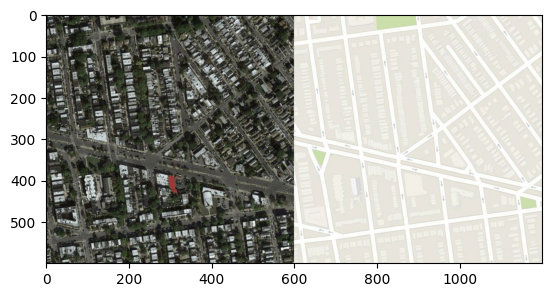

In [4]:
dataset_name = "maps"#@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'
# get_file function is used to download the dataset file and extract it
path2zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", origin = _URL, extract= True)
# pathlib.Path is module is used to handle file paths
path2zip = pathlib.Path(path2zip)
# 'PATH' variable represents the path to the extracted dataset.
PATH = path2zip.parent/dataset_name

#  tf.io.read_file function reads the file content as a binary string
sample_image = tf.io.read_file(str(PATH/'train/1.jpg'))
# tf.io.decode_jpeg decodes the binary string into a tensor representing the image
sample_image = tf.io.decode_jpeg(sample_image)
print(f'shape of the sample image is: {sample_image.shape}')
plt.figure()
plt.imshow(sample_image)

# Generator Model

In [36]:
# Encoder
Output_channel = 3
def downsample (filters: int, kernel_size: int, apply_batchnorm: bool=True):
    """ this function applies down sampling in the Encoder part of Unet Generator model

    Args:
        filters (int): number of filters in the convolutional layer
        kernel_size (int): size of the filters
        apply_batchnorm (bool, optional): applying batch normalization after the convolutional layer. Defaults to True.
    """
    initializer = tf.random_normal_initializer (0., 0.02)
    downsampled_feature_map = tf.keras.Sequential()
    downsampled_feature_map.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias = False))
    if apply_batchnorm:
        downsampled_feature_map.add(tf.keras.layers.BatchNormalization())
    downsampled_feature_map.add(tf.keras.layers.LeakyReLU())
    return downsampled_feature_map

sample_input = tf.random.normal([64, 64, 3])
down_model = downsample(filters=15,kernel_size=3)
down_result = down_model(tf.expand_dims(sample_input, 0))
print(down_result.shape)

# Decoder
def upsample(filters: int, kernel_size: int, apply_dropout : bool= False):
    """This is a function definition for creating an up sampling block in Encoder part of the Unet model

    Args:
        filters (int): number of filters in the transposed convolutional layer
        kernel_size (int):  size of the filters
        apply_dropout (bool, optional): applying drop out regularization after the transposed convolutional layer. Defaults to False.
    """
    initializer = tf.random_normal_initializer (0., 0.02)
    upsampled_feature_map = tf.keras.Sequential() 
    upsampled_feature_map.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding = 'same', kernel_initializer=initializer, use_bias= False ))
    upsampled_feature_map.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        upsampled_feature_map.add(tf.keras.layers.Dropout(0.5))
    upsampled_feature_map.add(tf.keras.layers.ReLU())
    return upsampled_feature_map


def Generator():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(filters=64, kernel_size=4, apply_batchnorm=False),
        downsample(filters=128, kernel_size=4, apply_batchnorm=True),
        downsample(filters=256, kernel_size=4, apply_batchnorm=True),
        downsample(filters=512, kernel_size=4, apply_batchnorm=True),
        downsample(filters=512, kernel_size=4, apply_batchnorm=True),
        downsample(filters=512, kernel_size=4, apply_batchnorm=True),
        downsample(filters=512, kernel_size=4, apply_batchnorm=True),
        downsample(filters=512, kernel_size=4, apply_batchnorm=True),
    ]
    
    up_stack = [
        upsample(filters=512, kernel_size=4, apply_dropout=True),
        upsample(filters=512, kernel_size=4, apply_dropout=True),
        upsample(filters=512, kernel_size=4, apply_dropout=True),
        upsample(filters=512, kernel_size=4, apply_dropout=False),
        upsample(filters=256, kernel_size=4, apply_dropout=False),
        upsample(filters=128, kernel_size=4, apply_dropout=False),
        upsample(filters=64, kernel_size=4, apply_dropout=False),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last_layer = tf.keras.layers.Conv2DTranspose (filters = Output_channel, kernel_size = 5, strides = 3, padding= 'same', kernel_initializer= initializer, activation= 'tanh')
    
    x= inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip (up_stack, skips):
        x = up(x)
        x= tf.keras.layers.Concatenate()([x, skip])
    
    x= last_layer (x)
    generative_model = tf.keras.Model(inputs = inputs, outputs = x)
    return generative_model
gen_model = Generator()


(1, 32, 32, 15)


# Generator Loss

In [37]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits= True)
def generator_loss(disc_generated_output, gen_output, target):
    """this function calculates the loss value for the generator

    Args:
        disc_generated_output (tf.Tensor): output of the discriminator for the generated output
        gen_output (tf.Tensor): generated output from generator
        target (tf.Tensor): ground truth

    Returns:
        Tensor: it returns three different loss values
    """
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    L1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * L1_loss)
    return total_gen_loss, gan_loss, L1_loss

# Discriminator Model

In [38]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256,256,3], name = 'input_image')
    tar = tf.keras.layers.Input(shape=[256,256,3], name = 'target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = downsample (filters = 64,   kernel_size=4, apply_batchnorm = False) (x)
    down2 = downsample (filters = 128, kernel_size=4, apply_batchnorm = True) (down1)
    down3 = downsample (filters = 256, kernel_size=4, apply_batchnorm = True) (down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D (filters= 512, kernel_size= 4 , strides= 1, kernel_initializer= initializer, use_bias= False) (zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    output = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    discriminator_model = tf.keras.Model(inputs = [inp, tar], outputs = output)
    return discriminator_model

disc_model = Discriminator()

# Discriminator Loss

In [39]:
def discriminator_loss(disc_real_output, disc_generated_output):
    """

    Args:
        disc_real_output (tf.Tensor): Discriminator's output for real images
        disc_generated_output (tf.Tensor): Discriminator's output for generated/fake images

    Returns:
        Tensor: Total loss value
    """
    # label of real image = 1   label of fake image = 0
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_real_output), disc_generated_output)
    total_disc_loss= real_loss + generated_loss
    return total_disc_loss

# Optimizers

In [42]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1= 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1= 0.5)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                                     discriminator_optimizer = discriminator_optimizer,
                                                     discriminator = disc_model,
                                                     generator = gen_model,
                                                     )

# Image Generation

In [43]:
def generate_images(model, test_input, tar):
    """This function allows you to generate and visualize the input image, ground truth image, and predicted image using a generator model.

    Args:
        model (tf.keras.Model): The trained generator model that takes the input image and generates the predicted image.
        test_input (tf.Tensor): A tensor representing the input image to the generator. Shape is expected to be [batch_size, height, width, channels].
        tar (tf.Tensor): A tensor representing the target or ground truth image. It should have the same shape as the `test_input` (excluding batch size).
    """
    prediction = model ( test_input, training= True)
    plt.figure(figsize= (15,15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title= ['Input Image', 'Ground Truth', 'Prediction Image']
    for i in range(3):
        plt.subplot(1,3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    